In [47]:
%reset -sf

In [86]:
import torch
from torch.utils.checkpoint import checkpoint
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm
from opt_einsum import contract
from torch.profiler import profile, record_function, ProfilerActivity
def _toN(t):
    return t.detach().cpu().numpy()
def printDiff(name,value,ref):
    if ref is not None:
        print(name+':',value,'diff(abs):',value-ref)
    else:
        print(name+':',value)
    
import ast
def eval_np_array_literal(array_string):
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.array(ast.literal_eval(array_string))


# SRG BaseClass

In [91]:
# SRG BaseClass, can be used for HOTRG-like and XTRG-like contraction
class SRG(torch.nn.Module):
    def __init__(self,params,options):
        super(SRG,self).__init__()
        self.dtype={'float64':torch.float64,'float32':torch.float32}[options.get('dtype','float64')]
        self.device=options.get('device','cpu')
        self.max_dim=options.get('max_dim',16)
        self.nLayers=options.get('nLayers',20)
        self.use_checkpoint=options.get('use_checkpoint',True)
        self.observable_checkerboard=False
        
        self.params=torch.nn.ParameterDict({
            k:torch.nn.Parameter(torch.tensor(v,dtype=self.dtype,device=self.device)) for k,v in params.items()
        })
        self.persistent={}
        self.persistent['logZ']=0
        
    def __str__(self):
        rtval=""
        for k,v in self.params.items():
            rtval+=k+':'+v+'\n'
        rtval+='dtype:'+self.dtype+'\n'
        rtval+='device:'+self.device+'\n'
        rtval+='max_dim:'+self.max_dim+'\n'
        rtval+='nLayers:'+self.nLayers+'\n'
        rtval+='nSite:'+2**nLayers+'\n'
        
    def set_params(self,params):
        self.params=torch.nn.ParameterDict({
            k:torch.nn.Parameter(torch.tensor(v,dtype=self.dtype,device=self.device)) for k,v in params.items()
        })
        
    def toT(self,t):
        return torch.tensor(t,dtype=self.dtype,device=self.device)
    
    def generate_random_Isometry(self,dim1,dim2):
        dim=max(dim1,dim2)
        A=torch.randn(dim,dim,dtype=self.dtype,device=self.device)
        U=torch.matrix_exp(A-A.t())
        U=U[:dim1,:dim2]
        return U
    
    def TRG_same_T(self,T,*w):
        return self.TRG(T,T,*w)
    
    def _checkpoint(self,F,*ww):
        requires_grad=False
        for w in ww:
            if w.requires_grad:
                requires_grad=True
        if self.use_checkpoint and requires_grad:
            return torch.utils.checkpoint.checkpoint(F,*ww)
        else:
            return F(*ww)
    
    def forward_tensor(self,nLayers):
        logTotal=0
        T=self.get_T0()
        for i in range(nLayers):
            w=self.ws[(i*self.w_per_layer):((i+1)*self.w_per_layer)]
            T=self._checkpoint(self.TRG_same_T,T,*w)
                
            norm=torch.linalg.norm(T)
            T=T/norm
            logTotal=2*logTotal+torch.log(norm)
        return T,logTotal
    
    def forward_tensor_with_observable(self,nLayers,T_op,contract_method=None,start_layer=0):
        T=self.get_T0()
        for i in range(start_layer):
            w=self.ws[(i*self.w_per_layer):((i+1)*self.w_per_layer)]
            T=self._checkpoint(self.TRG_same_T,T,*w)
            
        logTotal=0
        print(nLayers)
        contracted=torch.zeros(nLayers,dtype=self.dtype,device=self.device)
        for i in range(start_layer,nLayers):
            w=self.ws[(i*self.w_per_layer):((i+1)*self.w_per_layer)]
            T1=self._checkpoint(self.TRG_same_T,T,*w)
            T2=self._checkpoint(self.TRG,T,T_op,*w)
            T3=self._checkpoint(self.TRG,T_op,T,*w)
            if self.observable_checkerboard and i<self.spacial_dim:
                T3=-T3

            T,T_op=T1,(T2+T3)/2
            norm=torch.linalg.norm(T)
            T,T_op=T/norm,T_op/norm
            logTotal=2*logTotal+torch.log(norm)
            
            if contract_method is not None:
                Z=contract(T,contract_method)
                Z_op=contract(T_op,contract_method)
                contracted[i]=Z_op/Z
            
        return T,T_op,logTotal,contracted
    
    
    #def dlogZ(self,param):
    #    self.requires_grad_(False)
    #    self.params[param].requires_grad_(True)
    #    self.zero_grad()
    #    logZ=self.forward(self.nLayers+self.nLayers_HOSVD)
    #    logZ.backward()
    #    result=_toN(self.params[param].grad)
    #    self.params[param].requires_grad_(False)
    #    return result
    
    def update_single_layer(self,layer):
        self.requires_grad_(False)
        
        for i in range(layer*self.w_per_layer,(layer+1)*self.w_per_layer):
            self.ws[i].requires_grad_(True)
        self.zero_grad()
        
        logZ=self.forward(self.nLayers)
        logZ.backward()
        
        with torch.no_grad():
            for i in range(layer*self.w_per_layer,(layer+1)*self.w_per_layer):
                E=self.ws[i].grad
                dim1,dim2=E.shape[0],E.shape[2]
                E=E.reshape(dim1*dim1,dim2)
                U,S,Vh=torch.linalg.svd(E,full_matrices=False)
                UVh=U@Vh
                #UVh=svd2UVh(E)
                del U,S,Vh,E
                
                #calculate diff
                UVh_old=self.ws[i].reshape(dim1*dim1,dim2)
                self.ws_diff[i]=_toN(torch.norm(UVh_old.t()@UVh@UVh.t()@UVh_old-torch.eye(dim2,device=UVh.device)))
                del UVh_old
                    
                self.ws[i].data=UVh.reshape(dim1,dim1,dim2)
                del UVh
                torch.cuda.empty_cache()
        return _toN(logZ)
        
    def optimize(self,nIter):
        self.ws_diff=np.zeros(len(self.ws))
        
        torch.cuda.empty_cache()
        if nIter>1:
            pbar2=tqdm(range(nIter), leave=False)
            pbar2.set_postfix({k:_toN(v) for k,v in self.params.items()})
        else:
            pbar2=range(nIter)
        for i in pbar2:
            pbar=tqdm([*range(self.nLayers-1,-1,-1)]+[*range(self.nLayers)], leave=False)
            for j in pbar:
                ws_shape=self.ws[j*self.w_per_layer].shape
                if ws_shape[0]**2>ws_shape[2]:
                    self.logZ=self.update_single_layer(j)
                #else:
                #    print(f'Skip layer {j} shape={ws_shape}')
        #lock all grads
        for param in self.params.values(): 
            param.requires_grad_(False)
        for i in range(self.nLayers): #slightly faster
            self.ws[i].requires_grad_(False)
        
        self.logZ_diff=np.abs(self.persistent['logZ']-self.logZ)
        self.persistent['logZ']=self.logZ
        
        # normalized by layer weight, number of elements in tensor
        # NOT USED but multiply by number of elements in last tensor to better match the effects in output
        self.ws_diff_normalized=np.zeros(len(self.ws))
        for i in range(self.nLayers):
            for j in range(self.w_per_layer):
                ij=i*self.w_per_layer+j
                self.ws_diff_normalized[ij]=self.ws_diff[ij]/2**i#/torch.numel(self.ws[ij])*torch.numel(self.ws[-1])
        # ignore the last layers we take trace directly
        # use 10-norm so layers of large error has beter contribution       
        self.ws_diff_total=np.average(self.ws_diff_normalized[:-self.w_per_layer*self.spacial_dim])


In [92]:
class HOTRG(SRG):
    def __init__(self,params,options):
        super(HOTRG,self).__init__(params,options)
        self.nLayers_HOSVD=options.get('nLayers_HOSVD',0)
        self.persistent['magnetization']=0
        self.persistent['energy']=0
    
    def create_isometries(self,start_dim,spacial_dim):
        ws=[]
        bond_dim=[start_dim]*spacial_dim
        for i in range(self.nLayers+self.nLayers_HOSVD):
            for j in range(1,spacial_dim):
                old_dim=bond_dim[j]
                new_dim=min(old_dim**2,self.max_dim)
                U=self.generate_random_Isometry(old_dim**2,new_dim).view(old_dim,old_dim,new_dim)
                ws.append(U.detach())
                bond_dim[j]=new_dim
            bond_dim=bond_dim[1:]+[bond_dim[0]]
        self.ws=torch.nn.ParameterList([
            torch.nn.Parameter(v) for v in ws
        ])
        self.w_per_layer=spacial_dim-1
        self.spacial_dim=spacial_dim
        self.TRG={2:self.HOTRG2D,3:self.HOTRG3D}[self.spacial_dim]
        self.HOSVD={2:self.HOSVD2D,3:self.HOSVD3D}[self.spacial_dim]
        self.ws_diff_normalized=np.zeros(len(self.ws))
        self.ws_diff=np.zeros(len(self.ws))
        self.ws_diff_total=0
        
        
    def HOTRG2D(self,T1,T2,w):
        return contract('ijkl,jmno,kna,lob->abim',T1,T2,w,w)#contract and rotate
    
    def HOTRG3D(self,T1,T2,w1,w2):
        return contract('ijklmn,jopqrs,kpa,lqb,mrc,nsd->abcdio',T1,T2,w1,w1,w2,w2)#contract and rotate
    
    def HOSVD2D(self,T1,T2):
        MM1=contract('ijkl,jmno,ipql,pmro->knqr',T1,T2,T1.conj(),T2.conj()).reshape(T1.shape[2]*T2.shape[2],-1)
        S1,U1=torch.linalg.eigh(MM1) #S1 ascending U S Uh=MM
        eps1=torch.sum(torch.abs(S1[-self.max_dim:])) # might be slightly minus due to numerical error
        
        MM2=contract('ijkl,jmno,ipql,pmro->knqr',T1.transpose(2,3),T2.transpose(2,3),T1.conj().transpose(2,3),T2.conj().transpose(2,3)).reshape(T1.shape[3]*T2.shape[3],-1)
        S2,U2=torch.linalg.eigh(MM2)
        eps2=torch.sum(torch.abs(S2[-self.max_dim:]))

        S,U=(S1,U1) if eps1<eps2 else (S2,U2)
        w=U[:,-self.max_dim:].reshape(T1.shape[2],T2.shape[2],-1)
        return contract('ijkl,jmno,kna,lob->abim',T1,T2,w,w),[w]
    
    def HOSVD3D(self,T1,T2):
        #print(T1.shape)
        MM1=contract('ijklmn,jopqrs,itulmn,tovqrs->kpuv',T1,T2,T1.conj(),T2.conj()).reshape(T1.shape[2]*T2.shape[2],-1)
        S1,U1=torch.linalg.eigh(MM1) #S1 ascending U S Uh=MM
        eps1=torch.sum(torch.abs(S1[-self.max_dim:])) # might be slightly minus due to numerical error
        
        MM2=contract('ijklmn,jopqrs,itulmn,tovqrs->kpuv',T1.transpose(2,3),T2.transpose(2,3),T1.conj().transpose(2,3),T2.conj().transpose(2,3)).reshape(T1.shape[3]*T2.shape[3],-1)
        S2,U2=torch.linalg.eigh(MM2)
        eps2=torch.sum(torch.abs(S2[-self.max_dim:]))

        S,U=(S1,U1) if eps1<eps2 else (S2,U2)
        w1=U[:,-self.max_dim:].reshape(T1.shape[2],T2.shape[2],-1)
        
        MM1=contract('ijklmn,jopqrs,itklun,topqvs->mruv',T1,T2,T1.conj(),T2.conj()).reshape(T1.shape[4]*T2.shape[4],-1)
        S1,U1=torch.linalg.eigh(MM1) #S1 ascending U S Uh=MM
        eps1=torch.sum(torch.abs(S1[-self.max_dim:])) # might be slightly minus due to numerical error
        
        MM2=contract('ijklmn,jopqrs,itklun,topqvs->mruv',T1.transpose(4,5),T2.transpose(4,5),T1.conj().transpose(4,5),T2.conj().transpose(4,5)).reshape(T1.shape[5]*T2.shape[5],-1)
        S2,U2=torch.linalg.eigh(MM2)
        eps2=torch.sum(torch.abs(S2[-self.max_dim:]))

        S,U=(S1,U1) if eps1<eps2 else (S2,U2)
        w2=U[:,-self.max_dim:].reshape(T1.shape[4],T2.shape[4],-1)
        #print(w1.shape,w2.shape)
        
        return contract('ijklmn,jopqrs,kpa,lqb,mrc,nsd->abcdio',T1,T2,w1,w1,w2,w2),[w1,w2]
    
    
    def generate_isometries_HOSVD(self):
        with torch.no_grad():
            logTotal=0
            T=self.get_T0()
            for i in tqdm(range(self.nLayers+self.nLayers_HOSVD), leave=False):
                T,ww=self.HOSVD(T,T)
                for j in range(self.w_per_layer):
                    self.ws[i*self.w_per_layer+j].data=ww[j]
                norm=torch.linalg.norm(T)
                T=T/norm
                logTotal=2*logTotal+torch.log(norm)

            contract_all=[i for i in range(len(T.shape)//2) for j in range(2)]
            Z=contract(T,contract_all)
            self.persistent['logZ']=self.logZ=_toN((torch.log(Z)+logTotal)/2**self.nLayers)
    
    def forward(self,nLayers):
        T,logTotal=self.forward_tensor(nLayers)
        contract_all=[i for i in range(len(T.shape)//2) for j in range(2)]
        Z=contract(T,contract_all)
        return (torch.log(Z)+logTotal)/2**nLayers
    
    def forward_with_observable(self,T_op,nLayers,start_layer=0):
        contract_method=[i for i in range(len(T_op.shape)//2) for j in range(2)]
        _,_,_,contracted=self.forward_tensor_with_observable(T_op,nLayers,contract_method=contract_method,start_layer=start_layer)
        return contracted,contracted[-1]
    
    #def forward_and_HOTRG(self):
    #    T,logTotal=self.forward_tensor()
    #    for i in range(self.nLayers_HOSVD):
    #        #T,_=self.HOSVD(T,T)
    #        ws=
    #        T=self.TRG(T,T,*ws)
    #        norm=torch.linalg.norm(T)
    #        T=T/norm
    #        logTotal=2*logTotal+torch.log(norm)
    #    contract_all=[i for i in range(len(T.shape)//2) for j in range(2)]
    #    Z=contract(T,contract_all)
    #    return (torch.log(Z)+logTotal)/2**(self.nLayers+self.nLayers_HOSVD)
    #
    #def forward_with_observable_and_HOTRG(self,T_op,start_layer=0):
    #    contract_method=[i for i in range(len(T_op.shape)//2) for j in range(2)]
    #    T,T_op,logTotal,contracted=self.forward_tensor_with_observable(T_op,contract_method=contract_method,start_layer=start_layer)
    #    
    #    for i in range(self.nLayers_HOSVD):
    #        T1,ws=self.HOSVD(T,T)
    #        T2=self.TRG(T,T_op,*ws)
    #        T3=self.TRG(T_op,T,*ws)
    #        
    #        T,T_op=T1,(T2+T3)/2
    #        norm=torch.linalg.norm(T)
    #        T,T_op=T/norm,T_op/norm
    #        logTotal=2*logTotal+torch.log(norm)
    #        
    #    Z=contract(T,contract_method)
    #    Z_op=contract(T_op,contract_method)
    #    
    #    return contracted,Z_op/Z
    
    def calc_logZ(self):
        with torch.no_grad():
            self.logZ=_toN(self.forward(self.nLayers+self.nLayers_HOSVD))
            self.logZ_diff=np.abs(self.persistent['logZ']-self.logZ)
            self.persistent['logZ']=self.logZ
    
    def calc_magnetization(self):
        with torch.no_grad():
            a,b=self.forward_with_observable(self.get_SZT0(),self.nLayers+self.nLayers_HOSVD)
            self.magnetization_per_layer=_toN(torch.abs(a))
            self.magnetization=_toN(torch.abs(b))
            self.magnetization_diff=np.abs(self.persistent['magnetization']-self.magnetization)
            self.persistent['magnetization']=self.magnetization
            
    def calc_energy(self):
        with torch.no_grad():
            a,b=self.forward_with_observable(self.get_ET1(),self.nLayers+self.nLayers_HOSVD,start_layer=1)
            self.energy_per_layer=_toN(a)
            self.energy=_toN(b)
            self.energy_diff=np.abs(self.persistent['energy']-self.energy)
            self.persistent['energy']=self.energy
            
            
def NewRow(model,params,options):
    return {**params,**options,
                'logZ':model.logZ,
                'logZ_diff':model.logZ_diff,
                'magnetization':model.magnetization,
                'magnetization_diff':model.magnetization_diff,
                'magnetization_per_layer':model.magnetization_per_layer.copy(),
                'energy':model.energy,
                'energy_diff':model.energy_diff,
                'energy_per_layer':model.energy_per_layer.copy(),
                'ws_diff_total':model.ws_diff_total,
                'ws_diff':model.ws_diff.copy(),
                'ws_diff_normalized':model.ws_diff_normalized.copy(),
               }



# Ising

In [93]:
class Ising2D(HOTRG):
    default_params={'beta':0.4406867935097715,'h':0}
    def __init__(self,params,options):
        super(Ising2D,self).__init__(params,options)
        self.create_isometries(start_dim=2,spacial_dim=2)
        #self.TRG=self.HOTRG2D
        self.observable_checkerboard=False
        #self.persistent['magnetization']=0
        
    def get_T0(self):
        beta,h=self.params['beta'],self.params['h']
        a=torch.sqrt(torch.cosh(beta))
        b=torch.sqrt(torch.sinh(beta))
        W=torch.stack([torch.stack([a,b]),torch.stack([a,-b])])
        sz=torch.stack([torch.exp(beta*h),torch.exp(-beta*h)])
        return contract('Ai,Aj,Ak,Al,A->ijkl',W,W,W,W,sz)#UDLR
    
    def get_SZT0(self):
        beta,h=self.params['beta'],self.params['h']
        a=torch.sqrt(torch.cosh(beta))
        b=torch.sqrt(torch.sinh(beta))
        W=torch.stack([torch.stack([a,b]),torch.stack([a,-b])])
        sz=torch.stack([torch.exp(beta*h),-torch.exp(-beta*h)])
        return contract('Ai,Aj,Ak,Al,A->ijkl',W,W,W,W,sz)#UDLR
    
    def get_ET1(self):
        beta,h=self.params['beta'],self.params['h']
        a=torch.sqrt(torch.cosh(beta))
        b=torch.sqrt(torch.sinh(beta))
        W=torch.stack([torch.stack([a,b]),torch.stack([a,-b])])
        sz=torch.stack([torch.exp(beta*h),torch.exp(-beta*h)])
        nBonds=self.toT(self.spacial_dim)#each site correspond to one spin and two bonds
        Eij=torch.stack([torch.stack([-nBonds-h,nBonds]),torch.stack([nBonds,-nBonds+h])]) # shouldn't x2
        w=self.ws[0]
        #'ijkl,jmno,kna,lob->abim'
        return contract('Ai,Aj,Ak,Al,A,Bj,Bm,Bn,Bo,B,AB,kna,lob->abim',W,W,W,W,sz,W,W,W,W,sz,Eij,w,w)

class Ising3D(HOTRG):
    default_params={'beta':0.2216544,'h':0}
    def __init__(self,params,options):
        super(Ising3D,self).__init__(params,options)
        self.create_isometries(start_dim=2,spacial_dim=3)
        #self.TRG=self.HOTRG3D
        self.observable_checkerboard=False
        #self.persistent['magnetization']=0
        
    def get_T0(self):
        beta,h=self.params['beta'],self.params['h']
        a=torch.sqrt(torch.cosh(beta))
        b=torch.sqrt(torch.sinh(beta))
        W=torch.stack([torch.stack([a,b]),torch.stack([a,-b])])
        sz=torch.stack([torch.exp(beta*h),torch.exp(-beta*h)])
        return contract('Ai,Aj,Ak,Al,Am,An,A->ijklmn',W,W,W,W,W,W,sz)
    
    def get_SZT0(self):
        beta,h=self.params['beta'],self.params['h']
        a=torch.sqrt(torch.cosh(beta))
        b=torch.sqrt(torch.sinh(beta))
        W=torch.stack([torch.stack([a,b]),torch.stack([a,-b])])
        sz=torch.stack([torch.exp(beta*h),-torch.exp(-beta*h)])
        return contract('Ai,Aj,Ak,Al,Am,An,A->ijklmn',W,W,W,W,W,W,sz)
    
    def get_ET1(self):
        beta,h=self.params['beta'],self.params['h']
        a=torch.sqrt(torch.cosh(beta))
        b=torch.sqrt(torch.sinh(beta))
        W=torch.stack([torch.stack([a,b]),torch.stack([a,-b])])
        sz=torch.stack([torch.exp(beta*h),torch.exp(-beta*h)])
        nBonds=self.toT(self.spacial_dim)#each site correspond to one spin and three bonds
        Eij=torch.stack([torch.stack([-nBonds-h,nBonds]),torch.stack([nBonds,-nBonds+h])]) # shouldn't x2
        w1,w2=self.ws[0],self.ws[1]
        #'ijklmn,jopqrs,kpa,lqb,mrc,nsd->abcdio'
        return contract('Ai,Aj,Ak,Al,Am,An,A,Bj,Bo,Bp,Bq,Br,Bs,B,AB,kpa,lqb,mrc,nsd->abcdio',W,W,W,W,W,W,sz,W,W,W,W,W,W,sz,Eij,w1,w1,w2,w2)

# ising2d test

In [94]:
curve=pd.DataFrame()
for beta in tqdm(np.linspace(.42,.5,10)):
    ising=Ising2D({'beta':beta,'h':1e-3},{'nLayers':20,'max_dim':16,'device':'cuda:1','nLayers_HOSVD':20})
    
    ising.generate_isometries_HOSVD()
    
    ising.calc_logZ()
    ising.calc_magnetization()
    ising.calc_energy()
    logZ=ising.logZ
    m=ising.magnetization
    E=ising.energy
    
    nsrgIter=0
    if nsrgIter>0:
        ising.optimize(nsrgIter)
    ising.calc_logZ()
    ising.calc_magnetization()
    logZ1=ising.logZ
    m1=ising.magnetization
    E1=ising.energy
    
    curve=curve.append({'beta':beta,'logZ':logZ,'logZ1':logZ1,'magnetization':m,'magnetization1':m1,'energy':E,'energy1':E1},ignore_index=True)
    
    #ising.optimize(2)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

tensor([[[[9.9710e-04, 1.4957e+00],
          [1.4957e+00, 3.9578e-04]],

         [[1.4957e+00, 3.9578e-04],
          [3.9578e-04, 5.9369e-01]]],


        [[[1.4957e+00, 3.9578e-04],
          [3.9578e-04, 5.9369e-01]],

         [[3.9578e-04, 5.9369e-01],
          [5.9369e-01, 1.5710e-04]]]], device='cuda:1', dtype=torch.float64)


TypeError: zeros() received an invalid combination of arguments - got (Tensor, device=str, dtype=torch.dtype), but expected one of:
 * (tuple of ints size, *, tuple of names names, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of ints size, *, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


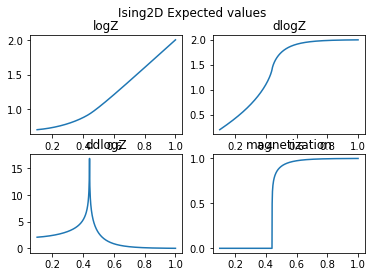

critical_beta 0.4406867935097715


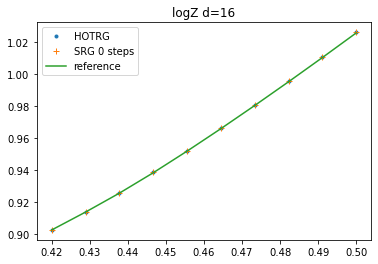

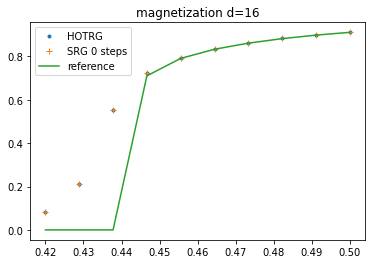

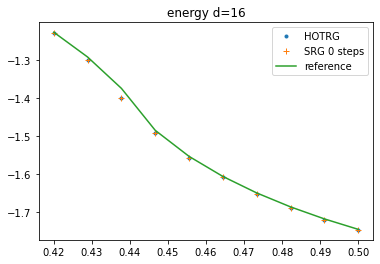

In [85]:
from IsingSolutions import Ising2DExactSolution
ising2dExactSolution=Ising2DExactSolution()
ising2dExactSolution.display()

plt.plot(curve['beta'],curve['logZ'],'.',label='HOTRG')
plt.plot(curve['beta'],curve['logZ1'],'+',label=f'SRG {nsrgIter} steps')
plt.plot(curve['beta'],ising2dExactSolution.logZ(curve['beta']),label='reference')
plt.legend()
plt.title(f'logZ d={ising.max_dim}')
plt.show()


plt.plot(curve['beta'],curve['magnetization'],'.',label='HOTRG')
plt.plot(curve['beta'],curve['magnetization1'],'+',label=f'SRG {nsrgIter} steps')
plt.plot(curve['beta'],ising2dExactSolution.magnetization(curve['beta']),label='reference')
plt.legend()
plt.title(f'magnetization d={ising.max_dim}')
plt.show()

plt.plot(curve['beta'],curve['energy'],'.',label='HOTRG')
plt.plot(curve['beta'],curve['energy1'],'+',label=f'SRG {nsrgIter} steps')
plt.plot(curve['beta'],-ising2dExactSolution.dlogZ(curve['beta']),label='reference') #E=-dlogZ/dbeta
plt.legend()
plt.title(f'energy d={ising.max_dim}')
plt.show()


# AKLT 

In [29]:
from scipy.special import comb
def get_CG_no_normalization(n):
    if n==0:
        return np.eye(1)
    CG=np.zeros((n+1,)+(2,)*n)
    for i in range(2**n):
        indices=tuple(map(int,bin(i)[2:].zfill(n)))
        m=np.sum(indices)
        CG[(m,)+indices]=1
    return CG
def get_CG(n):
    if n==0:
        return np.eye(1)
    CG=np.zeros((n+1,)+(2,)*n)
    for i in range(2**n):
        indices=tuple(map(int,bin(i)[2:].zfill(n)))
        m=np.sum(indices)
        CG[(m,)+indices]=1/np.sqrt(comb(n,m))
    return CG
def get_Singlet():
    return np.array([[0,1.],[-1.,0]])


class AKLT2D(HOTRG):
    default_params={'a1':np.sqrt(6)/2,'a2':np.sqrt(6)}
    def __init__(self,params,options):
        super(AKLT2D,self).__init__(params,options)
        self.create_isometries(start_dim=4,spacial_dim=2)
        #self.TRG=self.HOTRG2D
        self.observable_checkerboard=True
        #self.persistent['magnetization']=0
        
    def get_T0(self):
        projector=self.toT(get_CG_no_normalization(4))
        singlet=self.toT([[0,-1],[1,0]])
        ac0,ac1,ac2=self.toT(1),self.params['a1'],self.params['a2']
        deform=torch.stack([ac2,ac1,ac0,ac1,ac2])
        #deform=torch.stack([ac2*(1-2e-6),ac1*(1-1e-6),ac0,ac1*(1+1e-6),ac2*(1+2e-6)])
        node=contract('aijkl,im,kn,a->amjnl',projector,singlet,singlet,deform)
        return contract('aijkl,amnop->imjnkolp',node,node).reshape(4,4,4,4)#UDLR

    def get_SZT0(self):
        projector=self.toT(get_CG_no_normalization(4))
        singlet=self.toT([[0,-1],[1,0]])
        ac0,ac1,ac2=self.toT(1),self.params['a1'],self.params['a2']
        deform=torch.stack([ac2,ac1,ac0,ac1,ac2])
        #deform=torch.stack([ac2*(1-2e-6),ac1*(1-1e-6),ac0,ac1*(1+1e-6),ac2*(1+2e-6)])
        node=contract('aijkl,im,kn,a->amjnl',projector,singlet,singlet,deform)
        op=self.toT([2,1,0,-1,-2])
        return contract('aijkl,amnop,a->imjnkolp',node,node,op).reshape(4,4,4,4)#UDLR
    

class AKLT3D(HOTRG):
    default_params={'a1':np.sqrt(20/15),'a2':np.sqrt(20/6),'a3':np.sqrt(20/1)}
    def __init__(self,params,options):
        super(AKLT3D,self).__init__(params,options)
        self.create_isometries(start_dim=4,spacial_dim=3)
        #self.TRG=self.HOTRG3D
        self.observable_checkerboard=True
        #self.persistent['magnetization']=0
        
    def get_T0(self):
        projector=self.toT(get_CG_no_normalization(6))
        singlet=self.toT([[0,-1],[1,0]])
        ac0,ac1,ac2,ac3=self.toT(1),self.params['a1'],self.params['a2'],self.params['a3']
        deform=torch.stack([ac3,ac2,ac1,ac0,ac1,ac2,ac3])
        #deform=torch.stack([ac3*(1-3e-6),ac2*(1-2e-6),ac1*(1-1e-6),ac0,ac1*(1+1e-6),ac2*(1+2e-6),ac3*(1+3e-6)])
        node=contract('aijklmn,io,kp,mq,a->aojplqn',projector,singlet,singlet,singlet,deform)
        return contract('aijklmn,aopqrst->iojpkqlrmsnt',node,node).reshape(4,4,4,4,4,4)#UDLRFB

    def get_SZT0(self):
        projector=self.toT(get_CG_no_normalization(6))
        singlet=self.toT([[0,-1],[1,0]])
        ac0,ac1,ac2,ac3=self.toT(1),self.params['a1'],self.params['a2'],self.params['a3']
        deform=torch.stack([ac3,ac2,ac1,ac0,ac1,ac2,ac3])
        #deform=torch.stack([ac3*(1-3e-6),ac2*(1-2e-6),ac1*(1-1e-6),ac0,ac1*(1+1e-6),ac2*(1+2e-6),ac3*(1+3e-6)])
        node=contract('aijklmn,io,kp,mq,a->aojplqn',projector,singlet,singlet,singlet,deform)
        op=self.toT([3,2,1,0,-1,-2,-3])
        return contract('aijklmn,aopqrst,a->iojpkqlrmsnt',node,node,op).reshape(4,4,4,4,4,4)#UDLRFB
    


In [31]:
options={
    'dtype':'float64',
    'device':'cuda:1',
    'max_dim':10, # 10 discussed with wei
    'nLayers':60, # 30
    'use_checkpoint':True
}
params=AKLT3D.default_params
params['a3']=4.8
model=AKLT3D(params,options)
model.generate_isometries_HOSVD()

model.calc_logZ()
model.calc_magnetization()
print(model.magnetization)

  0%|          | 0/60 [00:00<?, ?it/s]

2.6971773616213186


# Testing

In [96]:
options={
    'dtype':'float64',
    'device':'cuda:0',
    'max_dim':16, # 50 for float32
    'nLayers':20,
    'use_checkpoint':True
}
alist=[2.5,2.7,2.9,3.1]
for a in alist:
    datapoint_name=f'{script_name}[{a:+.7f}]'
    params=AKLT2D.default_params
    params['a2']=a
    CreateDataPoint(datapoint_name,params,options, override=False)


/tmp/ipykernel_29744/1228470821.py:14: UserWarning: Skipped existed datapoint notebook[+2.5000000]
  warnings.warn('Skipped existed datapoint '+name)
/tmp/ipykernel_29744/1228470821.py:14: UserWarning: Skipped existed datapoint notebook[+2.7000000]
  warnings.warn('Skipped existed datapoint '+name)
/tmp/ipykernel_29744/1228470821.py:14: UserWarning: Skipped existed datapoint notebook[+2.9000000]
  warnings.warn('Skipped existed datapoint '+name)
/tmp/ipykernel_29744/1228470821.py:14: UserWarning: Skipped existed datapoint notebook[+3.1000000]
  warnings.warn('Skipped existed datapoint '+name)


In [97]:


for _iter in range(100):
    for a in alist:
        datapoint_name=f'{script_name}[{a:+.7f}]'
        Train(datapoint_name,Model=AKLT2D,NewRow=NewRow,nIter=1)

Training notebook[+2.5000000] iter 0
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 0
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 0
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 0
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 1
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 1
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 1
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 1
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 2
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 2
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 2
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 2
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 3
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 3
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 3
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 3
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 4
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 4
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 4
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 4
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 5
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 5
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 5
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 5
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 6
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 6
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 6
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 6
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 7
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 7
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 7
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 7
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 8
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 8
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 8
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 8
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 9
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 9
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 9
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 9
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 10
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 10
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 10
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 10
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 11
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 11
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 11
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 11
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 12
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 12
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 12
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 12
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 13
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 13
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 13
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 13
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 14
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 14
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 14
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 14
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 15
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 15
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 15
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 15
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 16
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 16
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 16
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 16
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 17
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 17
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 17
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 17
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 18
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 18
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 18
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 18
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 19
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 19
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 19
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 19
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 20
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 20
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 20
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 20
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 21
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 21
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 21
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 21
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 22
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 22
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 22
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 22
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 23
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 23
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 23
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 23
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 24
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 24
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 24
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 24
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 25
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 25
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 25
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 25
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 26
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 26
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 26
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 26
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 27
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 27
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 27
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 27
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 28
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 28
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 28
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 28
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 29
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 29
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 29
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 29
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 30
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 30
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 30
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 30
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 31
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 31
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 31
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 31
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 32
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 32
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 32
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 32
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 33
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 33
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 33
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 33
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 34
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 34
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 34
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 34
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 35
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 35
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 35
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 35
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 36
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 36
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 36
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 36
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 37
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 37
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 37
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 37
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 38
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 38
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 38
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 38
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 39
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 39
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 39
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 39
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 40
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 40
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 40
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 40
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 41
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 41
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 41
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 41
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 42
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 42
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 42
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 42
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 43
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 43
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 43
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 43
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 44
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 44
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 44
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 44
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 45
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 45
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 45
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 45
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 46
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 46
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 46
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 46
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 47
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 47
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 47
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 47
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 48
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 48
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 48
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 48
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 49
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 49
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 49
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 49
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 50
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 50
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 50
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 50
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 51
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 51
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 51
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 51
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 52
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 52
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 52
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 52
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 53
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 53
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 53
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 53
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 54
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 54
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 54
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 54
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 55
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 55
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 55
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 55
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 56
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 56
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 56
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 56
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 57
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 57
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 57
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 57
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 58
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 58
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 58
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 58
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 59
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 59
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 59
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 59
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 60
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 60
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 60
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 60
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 61
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 61
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 61
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 61
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 62
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 62
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 62
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 62
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 63
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 63
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 63
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 63
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 64
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 64
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 64
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 64
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 65
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 65
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 65
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 65
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 66
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 66
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 66
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 66
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 67
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 67
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 67
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 67
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 68
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 68
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 68
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 68
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 69
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 69
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 69
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 69
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 70
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 70
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 70
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 70
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 71
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 71
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 71
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 71
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 72
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 72
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 72
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 72
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 73
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 73
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 73
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 73
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 74
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 74
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 74
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 74
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 75
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 75
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 75
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 75
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 76
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 76
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 76
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 76
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 77
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 77
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 77
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 77
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 78
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 78
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 78
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 78
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 79
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 79
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 79
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 79
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 80
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 80
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 80
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 80
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 81
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 81
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 81
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 81
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 82
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 82
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 82
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 82
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 83
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 83
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 83
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 83
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 84
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 84
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 84
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 84
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 85
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 85
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 85
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 85
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 86
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 86
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 86
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 86
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 87
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 87
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 87
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+3.1000000] iter 87
{'a1': 1.224744871391589, 'a2': 3.1}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.5000000] iter 88
{'a1': 1.224744871391589, 'a2': 2.5}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.7000000] iter 88
{'a1': 1.224744871391589, 'a2': 2.7}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

Training notebook[+2.9000000] iter 88
{'a1': 1.224744871391589, 'a2': 2.9}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 16, 'nLayers': 20, 'use_checkpoint': True}


  0%|          | 0/40 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Testing

In [ ]:
a_arr=[1,2,3,4,5]

In [36]:
options={
    'dtype':'float64',
    'device':'cuda:0',
    'max_dim':8, # 10 discussed with wei
    'nLayers':21, # 30
    'use_checkpoint':True
}

for a in a_arr:
    datapoint_name=f'{script_name}[{a:+.7f}]'
    params=AKLT3D.default_params
    params['a3']=a
    CreateDataPoint(datapoint_name,params,options)


/tmp/ipykernel_29744/268712080.py:13: UserWarning: Skipped existed datapoint notebook[+1.0000000]
  warnings.warn('Skipped existed datapoint '+name)
/tmp/ipykernel_29744/268712080.py:13: UserWarning: Skipped existed datapoint notebook[+2.0000000]
  warnings.warn('Skipped existed datapoint '+name)
/tmp/ipykernel_29744/268712080.py:13: UserWarning: Skipped existed datapoint notebook[+3.0000000]
  warnings.warn('Skipped existed datapoint '+name)
/tmp/ipykernel_29744/268712080.py:13: UserWarning: Skipped existed datapoint notebook[+4.0000000]
  warnings.warn('Skipped existed datapoint '+name)
/tmp/ipykernel_29744/268712080.py:13: UserWarning: Skipped existed datapoint notebook[+5.0000000]
  warnings.warn('Skipped existed datapoint '+name)


In [ ]:


for _iter in range(100):
    for a in a_arr:
        datapoint_name=f'{script_name}[{a:+.7f}]'
        Train(datapoint_name,Model=AKLT3D,NewRow=NewRow,nIter=1)

Training notebook[+1.0000000] iter 2
{'a1': 1.1547005383792515, 'a2': 1.8257418583505538, 'a3': 1.0}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 8, 'nLayers': 21, 'use_checkpoint': True}


  0%|          | 0/42 [00:00<?, ?it/s]

Training notebook[+2.0000000] iter 2
{'a1': 1.1547005383792515, 'a2': 1.8257418583505538, 'a3': 2.0}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 8, 'nLayers': 21, 'use_checkpoint': True}


  0%|          | 0/42 [00:00<?, ?it/s]

Training notebook[+3.0000000] iter 0
{'a1': 1.1547005383792515, 'a2': 1.8257418583505538, 'a3': 3.0}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 8, 'nLayers': 21, 'use_checkpoint': True}


  0%|          | 0/42 [00:00<?, ?it/s]

Training notebook[+4.0000000] iter 0
{'a1': 1.1547005383792515, 'a2': 1.8257418583505538, 'a3': 4.0}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 8, 'nLayers': 21, 'use_checkpoint': True}


  0%|          | 0/42 [00:00<?, ?it/s]

Training notebook[+5.0000000] iter 0
{'a1': 1.1547005383792515, 'a2': 1.8257418583505538, 'a3': 5.0}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 8, 'nLayers': 21, 'use_checkpoint': True}


  0%|          | 0/42 [00:00<?, ?it/s]

Training notebook[+1.0000000] iter 3
{'a1': 1.1547005383792515, 'a2': 1.8257418583505538, 'a3': 1.0}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 8, 'nLayers': 21, 'use_checkpoint': True}


  0%|          | 0/42 [00:00<?, ?it/s]

Training notebook[+2.0000000] iter 3
{'a1': 1.1547005383792515, 'a2': 1.8257418583505538, 'a3': 2.0}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 8, 'nLayers': 21, 'use_checkpoint': True}


  0%|          | 0/42 [00:00<?, ?it/s]

Training notebook[+3.0000000] iter 1
{'a1': 1.1547005383792515, 'a2': 1.8257418583505538, 'a3': 3.0}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 8, 'nLayers': 21, 'use_checkpoint': True}


  0%|          | 0/42 [00:00<?, ?it/s]

Training notebook[+4.0000000] iter 1
{'a1': 1.1547005383792515, 'a2': 1.8257418583505538, 'a3': 4.0}
{'dtype': 'float64', 'device': 'cuda:0', 'max_dim': 8, 'nLayers': 21, 'use_checkpoint': True}


  0%|          | 0/42 [00:00<?, ?it/s]

# Checkpoint Mechanics

In [15]:
import os,torch
import pandas as pd
import time
import warnings

script_name=os.path.splitext(os.path.basename(__file__))[0] if '__file__' in globals() else 'notebook'

# Generate an empty checkpoint file defining the parameters and options
def CreateDataPoint(name,params,options,override=False):
    if os.path.exists(name+'.checkpoint'):
        if override:
            warnings.warn('Override existed datapoint '+name)
        else:
            warnings.warn('Skipped existed datapoint '+name)
            return
        
    
    
    # save the python dictionary containing parameters and options, 
    # later we will add model.state_dict(), which is the pytorch trained parameters, 
    # and model.persistent, which is some non-pytorch data I want to keep it for the next iteration
    torch.save({'params':params,'options':options,'iter':0},name+'.checkpoint')
    if os.path.exists(name+'.curve'):
        os.remove(name+'.curve')
    print('DataPoint Created:',name)
    print('options:',options)
    print('params:',params)

# todo test new function final_hotrg and init hotrg todo compare final hotrg with not with it

# Train an existed checkpoint file
# NewRow: a function callback which generate the rows for the curve
def Train(name,Model,NewRow,nIter,Models=None,device=None):
    # load the checkpoint    TODO add lock to the file
    checkpoint=torch.load(name+'.checkpoint',map_location=device)
    
    if os.path.exists(name+'.curve'):
        curve=pd.read_pickle(name+'.curve')
    else:
        curve=pd.DataFrame()
    
    # reconstruct the model
    if Models is not None:
        Model=Models[checkpoint['options']['model']]
    if device is not None:
        checkpoint['options']['device']=device
        
        
    print('Training',name,'iter',checkpoint['iter'])
    print(checkpoint['params'])
    print(checkpoint['options'])
        
    model=Model(checkpoint['params'],checkpoint['options'])
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
        model.persistent=checkpoint['model_persistent']
    else:
        if checkpoint['options']['init_with_HOSVD']:
            start_time=time.time()
            model.generate_isometries_HOSVD()
            model.calc_logZ()
            model.calc_magnetization()
            end_time=time.time()
            newRow=NewRow(model,checkpoint['params'],checkpoint['options'])
            newRow['iter']=checkpoint['iter']
            newRow['elapsed']=end_time-start_time
            
            curve=curve.append(newRow,ignore_index=True)
        
    # train the model
    start_time=time.time()
    
    model.optimize(nIter)
    model.calc_logZ()
    model.calc_magnetization()
    
    end_time=time.time()
    checkpoint['iter']+=nIter
    
    # add row
    
    # add row to the curve
    newRow=NewRow(model,checkpoint['params'],checkpoint['options'])
    newRow['iter']=checkpoint['iter']
    newRow['elapsed']=end_time-start_time
    
    curve=curve.append(newRow,ignore_index=True)
    curve.to_pickle(name+'.curve')
    curve.to_csv(name+'.curve.csv')
    
    # save the model
    checkpoint['model_state_dict']=model.state_dict()
    checkpoint['model_persistent']=model.persistent
    
    torch.save(checkpoint,name+'.checkpoint')
    
    return curve


# Command Line Tools

In [ ]:
if __name__ == "__main__":
    import argparse

    parser = argparse.ArgumentParser(description='SRG for 2D and 3D AKLT')


    #parser.add_argument('--create',action='store_true')
    #parser.add_argument('--train',action='store',metavar='ITER',help='number of iteration')

    subparsers=parser.add_subparsers(dest='command')

    parser1=subparsers.add_parser('create',help='create a datapoint')

    parser1.add_argument('datapoint_name')
    parser1.add_argument('--override',action='store_true',help='override existing datapoint')
    parser1.add_argument('--model',choices=['AKLT2D','AKLT3D','Ising2D','Ising3D'],required=True)

    parser1.add_argument('--dtype',default='float64')
    parser1.add_argument('--device',default='cpu')
    parser1.add_argument('--max_dim',type=int,default=16)
    parser1.add_argument('--nLayers',type=int,default=20)
    parser1.add_argument('--nLayers_HOSVD',type=int,default=0,help='Do HOSVD after SRG') #not implemented
    parser1.add_argument('--init_with_HOSVD',action='store_true',help='Use HOTRG to initialize weights') #not implemented

    parser1.add_argument('--a1',type=float)
    parser1.add_argument('--a2',type=float)
    parser1.add_argument('--a3',type=float)
    parser1.add_argument('--beta',type=float)
    parser1.add_argument('--h',type=float)

    parser2=subparsers.add_parser('train',help='train a datapoint')
    parser2.add_argument('datapoint_names',nargs='+',help='list of datapoints to train')
    parser2.add_argument('--iter',type=int,default=1,help='number of iteration')
    parser2.add_argument('--device',default=None,help='override device setting')

    args=parser.parse_args()


Models={'AKLT2D':AKLT2D,'AKLT3D':AKLT3D,'Ising2D':Ising2D,'Ising3D':Ising3D}

if __name__ == "__main__":
    if args.command=='create':
        options={
            'model':args.model,
            'dtype':args.dtype,
            'device':args.device,
            'max_dim':args.max_dim,
            'nLayers':args.nLayers,
            'use_checkpoint':True,
            'init_with_HOSVD':args.init_with_HOSVD,
            'nLayers_HOSVD':args.nLayers_HOSVD,
        }

        Model=Models[options['model']]
        params=Model.default_params
        for param_name in ['a1','a2','a3','beta','h']:
            if vars(args)[param_name] is not None:
                params[param_name]=vars(args)[param_name]


        CreateDataPoint(args.datapoint_name,params,options,override=args.override)

    if args.command=='train':

        for _i in tqdm(range(args.iter*len(args.datapoint_names))):
            datapoint_name=args.datapoint_names[_i%len(args.datapoint_names)]
            Train(datapoint_name,None,NewRow=NewRow,nIter=1,Models=Models,device=args.device)
        